In [1]:
from google.colab import drive
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import os
from scipy.io import loadmat
import numpy as np
import random
from keras.layers import Input, Add, multiply, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.special import kl_div
from scipy import signal
import scipy
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras.backend as K
from keras.utils import to_categorical
from sklearn.utils import class_weight

SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH)
ROOT_PATH = Path(ROOT_PATH) / 'My Drive' / 'AI_BIO_Project';

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset load & inspection

In [3]:
def load_data(path):
  subjects, frequencies, ppgs, peaks, labels = [], [], [], [], []
  files = os.listdir(path)
  f_names = []

  for file in files:
    f_names.append(file.split('_')[0])

  subjects = np.array(sorted(list(set(f_names)), key=lambda x: int(x[1:])))

  for s in subjects:
    subject_files = [f for f in files if f.startswith(s)]
    for sf in subject_files:
      if('ann' in sf):    #is the annotation file
        labels.append(list(loadmat(Path(path) / sf, simplify_cells = True)['labels']))
      elif('spk' in sf):  # is the peaks file
        peaks.append(list(loadmat(Path(path) / sf, simplify_cells = True)['speaks']))
        frequencies.append(int(sf.split('_')[1]))
      else:               # is the ppg file
        ppgs.append(list(loadmat(Path(path) / sf, simplify_cells = True)['ppg']))

  return subjects, frequencies, ppgs, peaks, labels

In [ ]:
dataset_path = Path(ROOT_PATH) / "dataset/train";
subjects, frequencies, ppgs, peaks, labels = load_data(path = dataset_path)

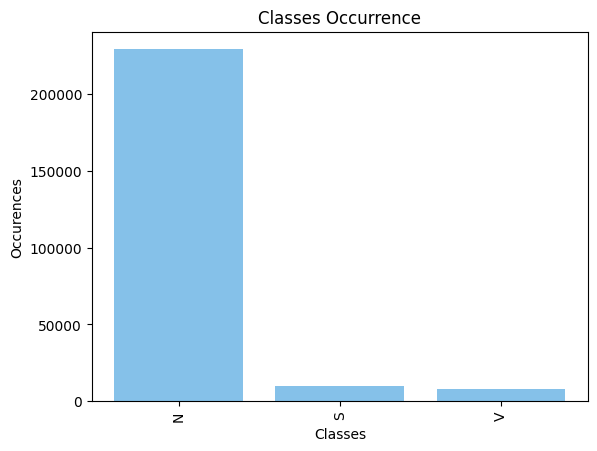

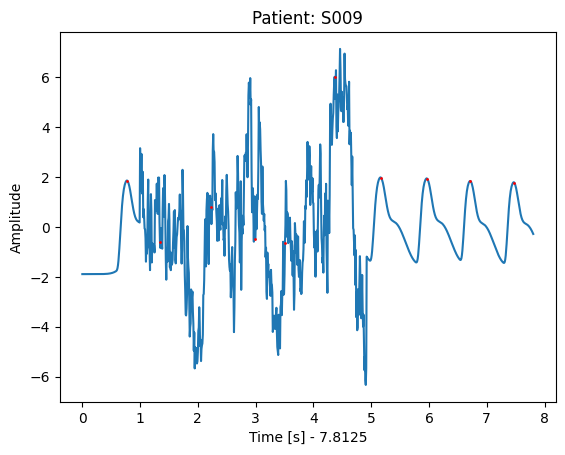

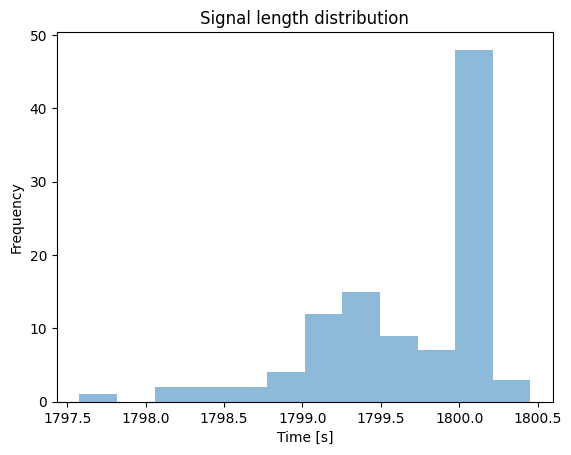

In [ ]:
def plot_subject(index):
  patient = subjects[index]
  signal_temp = ppgs[index][:1000]
  fs = frequencies[index]
  t = np.arange(0, len(signal_temp)/fs, 1/fs)
  fig, axs = plt.subplots()
  axs.set_title("Patient: " + patient)
  axs.plot(t, signal_temp, color='C0')
  axs.set_xlabel("Time [s] - " + str(len(signal_temp) / fs))
  axs.set_ylabel("Amplitude")
  peaks_values = [signal_temp[i] for i in peaks[index][:10]]
  axs.scatter([x / fs for x in peaks[index][:10]], peaks_values, color='red', s=1, zorder=2)
  plt.show()

def plot_signal_length_distribution():
  length_recordings = list()
  for i, rec_temp in enumerate(ppgs):
    length_recordings.append(len(rec_temp)/frequencies[i])

  length_rec_s = pd.Series(length_recordings)
  ax = length_rec_s.plot.hist(bins=12, alpha=0.5)
  ax.set_xlabel("Time [s]")
  ax.set_title("Signal length distribution")
  plt.show()

def original_distribution(labels):
  N, S, V = 0, 0, 0

  for i in range(len(labels)):
        if (labels[i] == 'N'):
            N += 1
        elif (labels[i] == 'S'):
            S += 1
        elif (labels[i] == 'V'):
            V += 1

  plt.bar(x=['N','S','V'],height=[N,S,V], facecolor ='#85c1e9')
  plt.title("Classes Occurrence", color = "black")
  plt.tick_params(axis="both", colors = "black")
  plt.xlabel("Classes", color = "black")
  plt.ylabel("Occurences", color = "black")
  plt.xticks(rotation=90)
  plt.yticks
  plt.show()

  return N, S, V


labels_copy = [c for sublist in labels for c in sublist]

original_distribution(labels_copy)
plot_subject(8)
plot_signal_length_distribution()

# Signal preprocessing

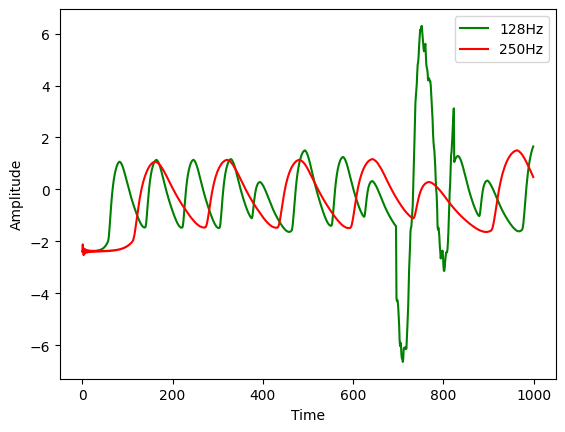

In [ ]:
signal_temp = ppgs[0][:1000]
fs = frequencies[0]
t = np.arange(0, len(signal_temp)/fs, 1/fs)
plt.plot(signal_temp, color='g')

resampled_ppgs = []
for i in range(len(ppgs)):
   signal_seconds = len(ppgs[i])/frequencies[i]
   n_samples = signal_seconds * 250
   resampled_ppgs.append(scipy.signal.resample(ppgs[i] , int(n_samples)))

signal_temp = resampled_ppgs[0][:1000]
fs = 250
t = np.arange(0, len(signal_temp)/fs, 1/fs)
plt.plot(signal_temp, color='r')
plt.legend(['128Hz', '250Hz'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.show()

In [ ]:
peaks_rescaled = []

for i in range(len(peaks)):
    tmp = []
    for j in range(len(peaks[i])):
        tmp.append(int(round(peaks[i][j] * (250 / frequencies[i]), 0)))

    peaks_rescaled.append(tmp)

In [ ]:
!pip install pywavelet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00


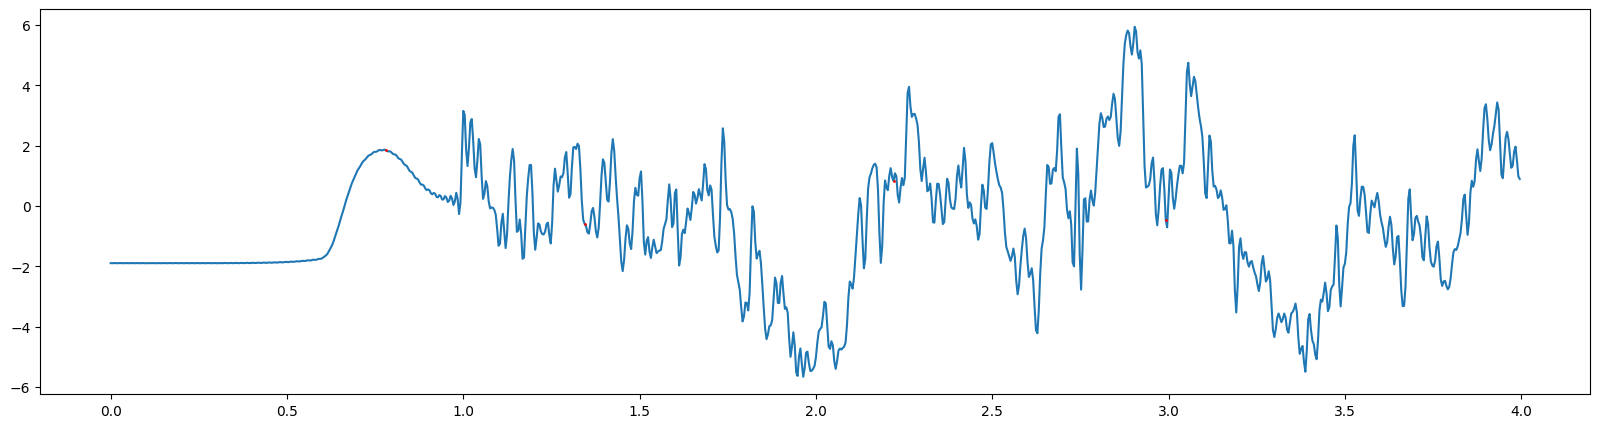

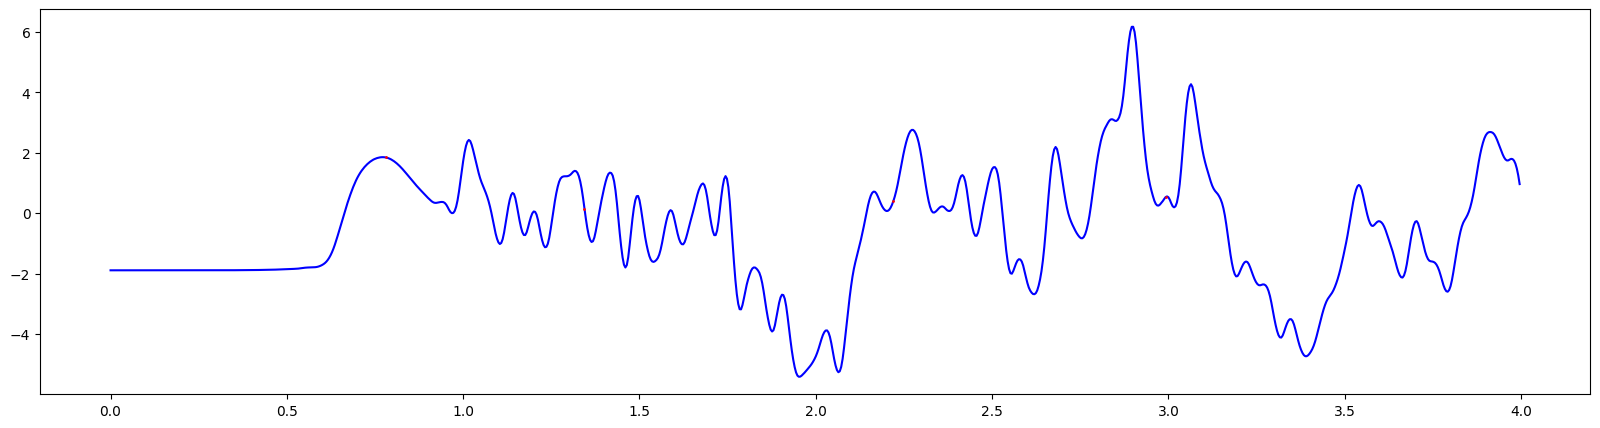

In [ ]:
import numpy as np
from skimage.restoration import denoise_wavelet
from skimage.restoration import estimate_sigma
import matplotlib.pyplot as plt

index = 8

plt.figure(figsize=(20, 5), dpi=100)
fs = 250
t = np.arange(0, len(resampled_ppgs[index][:1000])/fs, 1/fs)
plt.plot(t,resampled_ppgs[index][:1000])
peaks_values = [resampled_ppgs[index][i] for i in peaks_rescaled[index][:4]]
plt.scatter([x / fs  for x in peaks_rescaled[index][:4]], peaks_values, color='red', s=1, zorder=2)
plt.show()

x_denoise = denoise_wavelet(resampled_ppgs[index], sigma=2.5, wavelet="sym9", method='VisuShrink', wavelet_levels=3, mode='hard', rescale_sigma='True')

plt.figure(figsize=(20, 5), dpi=100)
fs = 250
t = np.arange(0, len(x_denoise[:1000])/fs, 1/fs)
plt.plot(t, x_denoise[:1000], 'b')
peaks_values = [x_denoise[i] for i in peaks_rescaled[index][:4]]
plt.scatter([x / fs  for x in peaks_rescaled[index][:4]], peaks_values, color='red', s=1, zorder=2)
plt.show()

In [ ]:
ppgs_denoised = []

for i in range(len(resampled_ppgs)):
  ppgs_denoised.append(denoise_wavelet(resampled_ppgs[i], sigma=2.5, wavelet="sym9", method='VisuShrink', wavelet_levels=3, mode='hard', rescale_sigma='True'))

print(len(resampled_ppgs))
print(len(ppgs_denoised))

105
105


In [ ]:
import warnings
from scipy.fft import fft, fftfreq

def sliding_window(signal, window_size):
    step = int(window_size)
    windows = []
    ranges = []

    idx = 0
    for i in range(0, len(signal) - window_size + 1, step):
        window = signal[i:i + window_size]
        ranges.append((i,i + window_size))
        windows.append(window)
        idx = i
    if(i + window_size < len(signal)):
      windows.append(signal[i + window_size:])
      ranges.append((i + window_size,len(signal-1)))

    return np.array(windows), ranges

def detect_outliers(signal, window_size, frequency, min_amplitude, max_amplitude, patience_factor, spectrum_hard_treshold):
  windows, ranges = sliding_window(signal, window_size = window_size);
  outliers = []
  min_treshold = -3
  max_treshold = 4

  treshold = len(windows[0]) * patience_factor

  for j, i in enumerate(windows):
    yf = fft(i)
    xf = fftfreq(len(i), 1/frequency)
    over_treshold = np.count_nonzero(i > max_amplitude)
    under_treshold = np.count_nonzero(i < min_amplitude)
    if(over_treshold >= treshold or under_treshold >= treshold or max(np.abs(yf)) > spectrum_hard_treshold):
      outliers.append(ranges[j])

  print(f"\t{len(outliers)} outliers detected!")
  return outliers, ranges, windows

def remove_outliers(signal, peaks, labels, window_size = 250, frequency = 250, min_amplitude = -3, max_amplitude = 4, patience_factor = 0.125, spectrum_hard_treshold = 400):
  print("\tCleaning the signal...")
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    outliers, ranges, windows = detect_outliers(signal, window_size, frequency, min_amplitude, max_amplitude, patience_factor,spectrum_hard_treshold)
  initial_duration = len(signal) / frequency
  clean_signal, clean_peaks, clean_labels = np.array([]), np.array([]), np.array([])
  cumulative_length = 0
  starting_window = ranges.index(outliers[0])

  for i, o in enumerate(windows[:-1]):
    if ranges[i] not in outliers:
      clean_signal = np.concatenate((clean_signal, windows[i]), axis=0)
      if(i < starting_window):
        bits_mask = np.logical_and(peaks >= ranges[i][0], peaks <= ranges[i][1])
        clean_peaks = np.concatenate((clean_peaks, peaks[bits_mask]), axis = 0)
        clean_labels = np.concatenate((clean_labels, labels[bits_mask]), axis = 0)
    
    else:
      cumulative_length += abs(ranges[i][1] - ranges[i][0])
      next_outlier = outliers.index(ranges[i])
      if(next_outlier + 1 < len(outliers)):
        bits_mask = np.logical_and(peaks >= ranges[i][1], peaks <= outliers[next_outlier + 1][0])
      else:
        bits_mask = np.logical_and(peaks >= ranges[i][1], peaks <= len(clean_signal))

      delta = peaks[bits_mask] - cumulative_length
      clean_peaks = np.concatenate((clean_peaks, delta), axis=0)
      clean_labels = np.concatenate((clean_labels, labels[bits_mask]), axis=0)

  i = len(windows) -1
  cumulative_length += abs(ranges[i][1] - ranges[i][0])
  bits_mask = np.logical_and(peaks >= ranges[i][1], peaks <= len(clean_signal))
  delta = peaks[bits_mask] - cumulative_length
  clean_peaks = np.concatenate((clean_peaks, delta), axis=0)
  clean_labels = np.concatenate((clean_labels, labels[bits_mask]), axis=0)

  final_duration = len(clean_signal) / frequency
  print(f"\tSignal cleaned, data loss from {initial_duration}s to {final_duration}s.\n")

  return clean_signal, clean_peaks.astype(int), clean_labels

In [ ]:
cleaned_signals = []
cleaned_peaks = []
cleaned_labels = []

for i, signal in enumerate(ppgs_denoised):
  print(f"Analysing denoised signal n° {i+1}...")
  cleaned, peaks, lbls = remove_outliers(signal, np.array(peaks_rescaled[i].copy()), np.array(labels[i]),
                                   window_size = 500,
                                   frequency = 250,
                                   min_amplitude = -4,
                                   max_amplitude = 4,
                                   patience_factor = 0.125,
                                   spectrum_hard_treshold = 350)
  cleaned_signals.append(cleaned)
  cleaned_peaks.append(peaks)
  cleaned_labels.append(lbls)

Analysing denoised signal n° 1...
	Cleaning the signal...
	357 outliers detected!
	Signal cleaned, data loss from 1799.904s to 1086.0s.

Analysing denoised signal n° 2...
	Cleaning the signal...
	382 outliers detected!
	Signal cleaned, data loss from 1799.492s to 1036.0s.

Analysing denoised signal n° 3...
	Cleaning the signal...
	426 outliers detected!
	Signal cleaned, data loss from 1799.176s to 948.0s.

Analysing denoised signal n° 4...
	Cleaning the signal...
	512 outliers detected!
	Signal cleaned, data loss from 1799.772s to 776.0s.

Analysing denoised signal n° 5...
	Cleaning the signal...
	437 outliers detected!
	Signal cleaned, data loss from 1799.28s to 926.0s.

Analysing denoised signal n° 6...
	Cleaning the signal...
	356 outliers detected!
	Signal cleaned, data loss from 1799.1s to 1088.0s.

Analysing denoised signal n° 7...
	Cleaning the signal...
	459 outliers detected!
	Signal cleaned, data loss from 1799.312s to 882.0s.

Analysing denoised signal n° 8...
	Cleaning the 

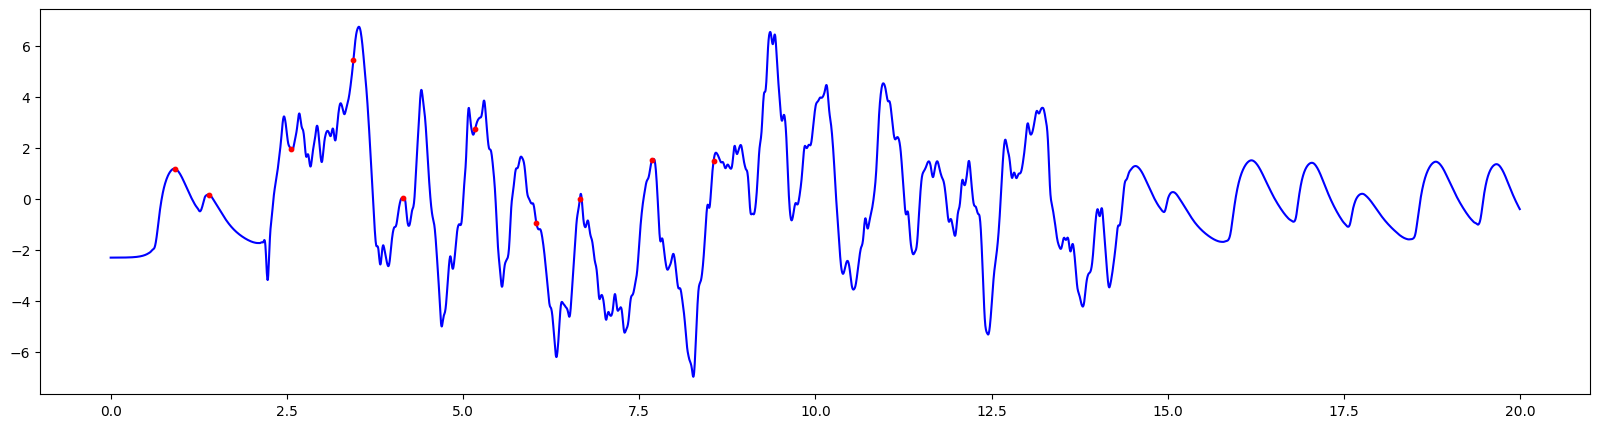

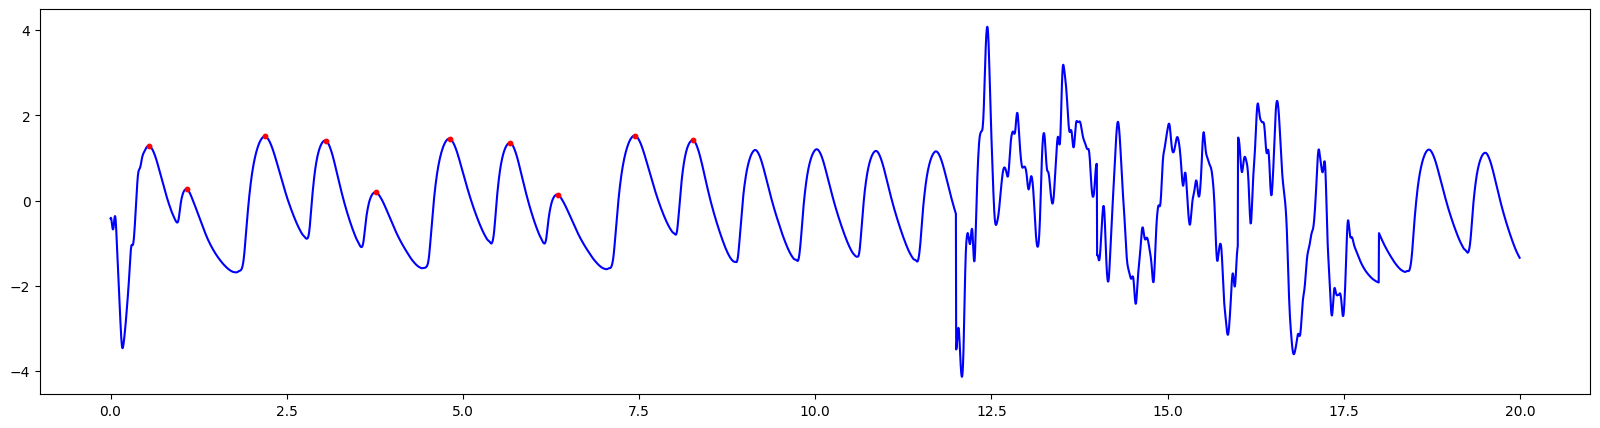

[162, 322, 482, 645, 770, 965, 1131, 1256, 1461, 1627, 1754, 1969, 2131, 2270, 2473]
[ 162  322  482  645  770  965 1127 1254 1469 1631 1770 1973 2137 2305
 2471]


In [ ]:
plt.figure(figsize=(20, 5), dpi=100)
fs = 250
index = 10
t = np.arange(0, len(ppgs_denoised[index][0:5000])/fs, 1/fs)
plt.plot(t, ppgs_denoised[index][0:5000], 'b')
peaks_values = [ppgs_denoised[index][i] for i in peaks_rescaled[index][0:10]]
plt.scatter([x / fs  for x in peaks_rescaled[index][0:10]], peaks_values, color='red', s=10, zorder=2)
plt.show()

plt.figure(figsize=(20, 5), dpi=100)
fs = 250
t = np.arange(0, len(cleaned_signals[index][0:5000])/fs, 1/fs)
plt.plot(t, cleaned_signals[index][0:5000], 'b')
peaks_values = [cleaned_signals[index][i] for i in cleaned_peaks[index][0:10]]
plt.scatter([x / fs  for x in cleaned_peaks[index][0:10]], peaks_values, color='red', s=10, zorder=2)
plt.show()

print(peaks_rescaled[0][0:15])
print(cleaned_peaks[0][0:15])

In [ ]:
print(len(labels[0]))
print(len(cleaned_labels[0]))


print(len(peaks_rescaled[0]))
print(len(cleaned_peaks[0]))

2603
1574
2603
1574


In [ ]:
percentages_dict = {'N':0, 'V':0, 'S':0}

for arr in labels:
    unique_values, counts = np.unique(arr, return_counts=True)
    for i, l in enumerate(unique_values):
      percentages_dict[l] += counts[i]

print('\n\n',percentages_dict)
print("N:", percentages_dict['N'] / (percentages_dict['N'] + percentages_dict['V'] + percentages_dict['S']) * 100)
print("S:", percentages_dict['S'] / (percentages_dict['N'] + percentages_dict['V'] + percentages_dict['S']) * 100)
print("V:", percentages_dict['V'] / (percentages_dict['N'] + percentages_dict['V'] + percentages_dict['S']) * 100)

percentages_dict = {'N':0, 'V':0, 'S':0}

for arr in cleaned_labels:
    unique_values, counts = np.unique(arr, return_counts=True)
    for i, l in enumerate(unique_values):
      percentages_dict[l] += counts[i]

print('\n\n',percentages_dict)
print("N:", percentages_dict['N'] / (percentages_dict['N'] + percentages_dict['V'] + percentages_dict['S']) * 100)
print("S:", percentages_dict['S'] / (percentages_dict['N'] + percentages_dict['V'] + percentages_dict['S']) * 100)
print("V:", percentages_dict['V'] / (percentages_dict['N'] + percentages_dict['V'] + percentages_dict['S']) * 100)



 {'N': 228929, 'V': 7994, 'S': 9691}
N: 92.82887427315562
S: 3.92962281135702
V: 3.2415029154873607


 {'N': 130415, 'V': 4456, 'S': 5550}
N: 92.87428518526431
S: 3.9524002820091013
V: 3.1733145327265864


In [ ]:
# Undersampling
indices_to_remove = []

for i, label_list in enumerate(cleaned_labels):
    if all(element == 'N' for element in label_list):
        indices_to_remove.append(i)

for index in reversed(indices_to_remove):
    del cleaned_labels[index]
    subjects = np.delete(subjects, index)
    del cleaned_peaks[index]
    del cleaned_signals[index]

# Print the results
print("New lists:")
print("labels:", len(cleaned_labels))
print("peaks:", len(cleaned_peaks))
print("ppgs:", len(cleaned_signals))
print("subjects:", len(subjects))

New lists:
labels: 87
peaks: 87
ppgs: 87
subjects: 87


# Datasets creation

In [ ]:
def compute_class_distribution(y_train, y_test):
  keys = set(y_train + y_test)
  sampl_train = len([i for subl in y_train for i in subl])
  sampl_test = len([i for subl in y_test for i in subl])
  train_count = Counter([i for subl in y_train for i in subl])
  test_count = Counter([i for subl in y_test for i in subl])
  train_distrib = {k: train_count[k] / sampl_train for k in keys}
  test_distrib = {k: test_count[k] / sampl_test for k in keys}
  sum_train = sum(train_distrib.values())
  train_distrib = {k: v / sum_train for k, v in train_distrib.items()}
  sum_test = sum(test_distrib.values())
  test_distrib = {k: v / sum_test for k, v in test_distrib.items()}
  return train_distrib, test_distrib


def create_dataset(subjects, frequence, ppgs, peaks, labels, half_window = 3, test_split = 0.2, stratify = True, stratification_trials = 200, max_seed = 5000, starting_seed = SEED):
  assert not stratification_trials > max_seed, "ERROR: max_seed must be grater than stratification_trials!"
  test_len = math.ceil(len(subjects) * test_split)
  train_len = math.floor(len(subjects) - test_len)
  ids, X, y = [], [], []
  ids_train, ids_test, X_train, X_test, y_train, y_test = [], [], [], [], [], []

  for i, s in enumerate(subjects):
    for j, peak in enumerate(peaks[i]):
        delta = int(half_window*frequence)
        zero_signal = np.arange(0,half_window*2*frequence, 1/frequence)
        beat = []
        if((peak - delta) < 0):
          beat = np.array(ppgs[i][0:peak + delta])
          beat = np.pad(beat, (delta - peak, 0), mode = 'constant')
          beat = beat.tolist()
        elif((peak + delta) > len(ppgs[i]) - 1):
          beat = np.array(ppgs[i][peak - delta:len(ppgs[i]) - 1])
          beat = np.pad(beat, (0, delta - (len(ppgs[i]) - 1 - peak)), mode = 'constant')
          beat = beat.tolist()
        else:
          beat = ppgs[i][peak - delta:peak + delta]
        ids.append(s)
        X.append(beat)
        y.append(labels[i][j])

  gss = GroupShuffleSplit(n_splits=1, random_state=starting_seed, test_size=test_split)
  for train_idx, test_idx in gss.split(X, y, groups = ids):
    ids_train, ids_test, X_train, X_test = [ids[i] for i in train_idx], [ids[i] for i in test_idx], [X[i] for i in train_idx], [X[i] for i in test_idx]
    y_train, y_test = [y[i] for i in train_idx], [y[i] for i in test_idx]

  if(stratify):
    p, q = compute_class_distribution(y_train, y_test)
    best_seed, best_kl = starting_seed, sum(kl_div(list(p.values()), list(q.values())))
    trials = {best_seed: best_kl}

    for i in range(stratification_trials):
      print("Trials " + str(i + 1) + "/" + str(stratification_trials))
      new_seed = random.randint(1, max_seed)
      while new_seed in trials.keys() or new_seed == SEED:
        new_seed = random.randint(1, max_seed)

      gss = GroupShuffleSplit(n_splits = 1, random_state = new_seed, test_size = test_split)
      for train_idx, test_idx in gss.split(X, y, groups = ids):
        ids_train, ids_test, X_train, X_test = [ids[i] for i in train_idx], [ids[i] for i in test_idx], [X[i] for i in train_idx], [X[i] for i in test_idx]
        y_train, y_test = [y[i] for i in train_idx], [y[i] for i in test_idx]

      p, q = compute_class_distribution(y_train, y_test)
      kl = sum(kl_div(list(p.values()), list(q.values())))
      trials[new_seed] = kl
      if(kl <= best_kl):
        best_kl = kl
        best_seed = new_seed

    print("best seed found: " + str(best_seed) + " (Kullback–Leibler divergence = " + str(best_kl) +")")

    gss = GroupShuffleSplit(n_splits = 1, random_state = best_seed, test_size = test_split)
    for train_idx, test_idx in gss.split(X, y, groups = ids):
      ids_train, ids_test, X_train, X_test = [ids[i] for i in train_idx], [ids[i] for i in test_idx], [X[i] for i in train_idx], [X[i] for i in test_idx]
      y_train, y_test = [y[i] for i in train_idx], [y[i] for i in test_idx]

  assert not len(set(ids_train).intersection(set(ids_test))), "ERROR: Subject shared between test"
  return ids_train, X_train, y_train, ids_test, X_test, y_test

In [ ]:
ids_train, X_train, y_train, ids_test, X_test, y_test = create_dataset(subjects, 250, cleaned_signals, cleaned_peaks, cleaned_labels,
                                                                       half_window = 0.5, test_split = 0.1, stratify = True,
                                                                       stratification_trials = 1000, max_seed = 500000,
                                                                       starting_seed = 414711)

Trials 1/1000
Trials 2/1000
Trials 3/1000
Trials 4/1000
Trials 5/1000
Trials 6/1000
Trials 7/1000
Trials 8/1000
Trials 9/1000
Trials 10/1000
Trials 11/1000
Trials 12/1000
Trials 13/1000
Trials 14/1000
Trials 15/1000
Trials 16/1000
Trials 17/1000
Trials 18/1000
Trials 19/1000
Trials 20/1000
Trials 21/1000
Trials 22/1000
Trials 23/1000
Trials 24/1000
Trials 25/1000
Trials 26/1000
Trials 27/1000
Trials 28/1000
Trials 29/1000
Trials 30/1000
Trials 31/1000
Trials 32/1000
Trials 33/1000
Trials 34/1000
Trials 35/1000
Trials 36/1000
Trials 37/1000
Trials 38/1000
Trials 39/1000
Trials 40/1000
Trials 41/1000
Trials 42/1000
Trials 43/1000
Trials 44/1000
Trials 45/1000
Trials 46/1000
Trials 47/1000
Trials 48/1000
Trials 49/1000
Trials 50/1000
Trials 51/1000
Trials 52/1000
Trials 53/1000
Trials 54/1000
Trials 55/1000
Trials 56/1000
Trials 57/1000
Trials 58/1000
Trials 59/1000
Trials 60/1000
Trials 61/1000
Trials 62/1000
Trials 63/1000
Trials 64/1000
Trials 65/1000
Trials 66/1000
Trials 67/1000
Tria

In [ ]:
val_refs = np.where(~np.isin(subjects, ids_test))[0]
ppgs_subset = []
peaks_subset = []
labels_subset = []

for i in val_refs:
  print(subjects[i])
  ppgs_subset.append(cleaned_signals[i])
  peaks_subset.append(cleaned_peaks[i])
  labels_subset.append(cleaned_labels[i])

print(len(ppgs_subset))

S001
S002
S003
S004
S005
S006
S007
S008
S009
S012
S013
S014
S015
S016
S017
S018
S019
S021
S022
S023
S024
S025
S026
S027
S028
S030
S031
S032
S033
S035
S036
S037
S038
S039
S040
S043
S044
S045
S046
S047
S048
S049
S050
S051
S052
S053
S054
S055
S056
S057
S058
S059
S060
S061
S062
S079
S080
S081
S082
S083
S084
S086
S087
S088
S089
S090
S091
S094
S099
S101
S102
S103
S106
S109
S113
S114
S117
S118
78


In [ ]:
ids_train, X_train, y_train, ids_val, X_val, y_val = create_dataset(subjects[val_refs], 250, ppgs_subset, peaks_subset, labels_subset,
                                                                       half_window = 0.5, test_split = 0.2, stratify = True,
                                                                       stratification_trials = 1000, max_seed = 500000,
                                                                       starting_seed = 414711)

Trials 1/1000
Trials 2/1000
Trials 3/1000
Trials 4/1000
Trials 5/1000
Trials 6/1000
Trials 7/1000
Trials 8/1000
Trials 9/1000
Trials 10/1000
Trials 11/1000
Trials 12/1000
Trials 13/1000
Trials 14/1000
Trials 15/1000
Trials 16/1000
Trials 17/1000
Trials 18/1000
Trials 19/1000
Trials 20/1000
Trials 21/1000
Trials 22/1000
Trials 23/1000
Trials 24/1000
Trials 25/1000
Trials 26/1000
Trials 27/1000
Trials 28/1000
Trials 29/1000
Trials 30/1000
Trials 31/1000
Trials 32/1000
Trials 33/1000
Trials 34/1000
Trials 35/1000
Trials 36/1000
Trials 37/1000
Trials 38/1000
Trials 39/1000
Trials 40/1000
Trials 41/1000
Trials 42/1000
Trials 43/1000
Trials 44/1000
Trials 45/1000
Trials 46/1000
Trials 47/1000
Trials 48/1000
Trials 49/1000
Trials 50/1000
Trials 51/1000
Trials 52/1000
Trials 53/1000
Trials 54/1000
Trials 55/1000
Trials 56/1000
Trials 57/1000
Trials 58/1000
Trials 59/1000
Trials 60/1000
Trials 61/1000
Trials 62/1000
Trials 63/1000
Trials 64/1000
Trials 65/1000
Trials 66/1000
Trials 67/1000
Tria

In [ ]:
print(len(X_train[0]))
print(set(len(arr) for arr in X_train))

126
{126}


In [ ]:
mean = np.mean(X_train, axis=1).mean(axis=0)
std = np.std(X_train, axis=1).mean(axis=0)

X_train = (X_train - mean)/std
X_val = (X_val - mean)/std
X_test = (X_test - mean)/std

train = pd.DataFrame(X_train, columns=[f'f{i+1}' for i in range(len(X_train[0]))])
train['ID'] = ids_train
train['class'] = y_train

val = pd.DataFrame(X_val, columns=[f'f{i+1}' for i in range(len(X_val[0]))])
val['ID'] = ids_val
val['class'] = y_val

test = pd.DataFrame(X_test, columns=[f'f{i+1}' for i in range(len(X_test[0]))])
test['ID'] = ids_test
test['class'] = y_test

print(train.head())

p, q = compute_class_distribution(y_train, y_val)
kl = sum(kl_div(list(p.values()), list(q.values())))
print(p, q, kl)
train.to_csv(Path(ROOT_PATH) / "dataset/stratified/train_cleaned.csv")
val.to_csv(Path(ROOT_PATH) / "dataset/stratified/val_cleaned.csv")
test.to_csv(Path(ROOT_PATH) / "dataset/stratified/test_cleaned.csv")

         f1        f2        f3        f4        f5        f6        f7  \
0 -2.724121 -2.713730 -2.704494 -2.696007 -2.688272 -2.680356 -2.670594   
1 -1.868494 -1.882453 -1.895964 -1.908489 -1.920064 -1.930356 -1.939113   
2 -1.877235 -1.891336 -1.904808 -1.917103 -1.928259 -1.938021 -1.946321   
3 -1.926591 -1.935000 -1.941388 -1.946830 -1.951859 -1.955729 -1.958947   
4 -1.033146 -1.060176 -1.087421 -1.115050 -1.142910 -1.170824 -1.198331   

         f8        f9       f10  ...      f119      f120      f121      f122  \
0 -2.657574 -2.639662 -2.616319  ... -0.858950 -0.889751 -0.920282 -0.950550   
1 -1.945921 -1.949549 -1.950023  ... -0.852205 -0.883548 -0.914609 -0.945394   
2 -1.952874 -1.956507 -1.957319  ... -0.844391 -0.875823 -0.906971 -0.937844   
3 -1.963034 -1.968075 -1.973465  ... -0.832937 -0.862873 -0.892300 -0.921301   
4 -1.225096 -1.251300 -1.276362  ... -1.173020 -1.194807 -1.216343 -1.237629   

       f123      f124      f125      f126    ID  class  
0 -0.980559

In [ ]:
df_train = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/train_cleaned.csv")
df_validation = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/val_cleaned.csv")
df_test = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/test_cleaned.csv")

print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)

(83610, 129)
(21592, 129)
(13125, 129)


In [ ]:
X_train = df_train.drop(columns=["class", "Unnamed: 0", "ID"])
y_train = df_train[['class']]
print(y_train.value_counts())

X_val = df_validation.drop(columns=["class", "Unnamed: 0", "ID"])
ids_val = df_validation[['ID']]
y_val = df_validation[['class']]
print(y_val.value_counts())

X_test = df_test.drop(columns=["class", "Unnamed: 0", "ID"])
ids_test = df_test[['ID']]
y_test = df_test[['class']]
print(y_test.value_counts())

class
N        76549
S         3927
V         3134
dtype: int64
class
N        19760
S         1001
V          831
dtype: int64
class
N        12012
S          622
V          491
dtype: int64


# Dataset resampling

Encoding categorical labels with One hot Encoding

In [ ]:
count_N = (y_train['class'] == 'N').sum()
count_S = (y_train['class'] == 'S').sum()
count_V = (y_train['class'] == 'V').sum()

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

encoded_train = ohe.fit_transform(integer_encoded)
y_train_encoded = encoded_train

original_categories = label_encoder.classes_
encoded_mapping = dict(zip(original_categories, label_encoder.transform(original_categories)))
print("Categorie originali:", original_categories)
print("Mapping delle categorie:", encoded_mapping)

X_train_array = np.array(X_train)
smote = SMOTE(random_state=SEED, sampling_strategy={0: count_N, 1: int(count_S * 6), 2: int(count_V * 6)})
X_train_smote, y_train_smote = smote.fit_resample(X_train, integer_encoded)

Categorie originali: ['N' 'S' 'V']
Mapping delle categorie: {'N': 0, 'S': 1, 'V': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[0 0 0 0 1 0 0 1 0 0]


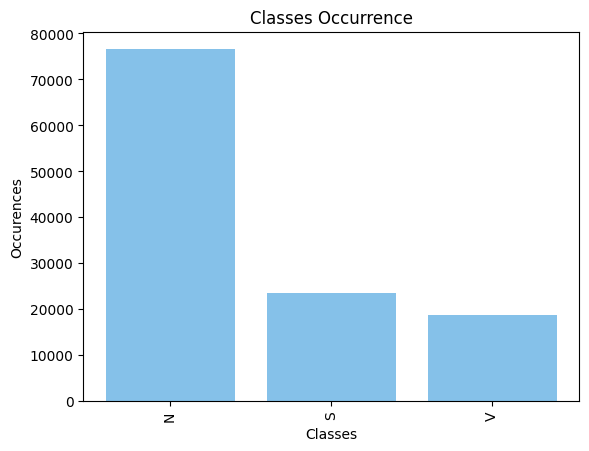

In [ ]:
def smote_oversampling_distribution(y_train):
    N, S, V = 0, 0, 0

    for i in range(len(y_train)):
          if (y_train[i] == 0):
              N += 1
          elif (y_train[i] == 1):
              S += 1
          elif (y_train[i] == 2):
              V += 1

    plt.bar(x=['N','S','V'],height=[N,S,V], facecolor ='#85c1e9')
    plt.title("Classes Occurrence", color = "black")
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Classes", color = "black")
    plt.ylabel("Occurences", color = "black")
    plt.xticks(rotation=90)
    plt.yticks
    plt.show()

    return N, S, V


print(y_train_smote[:10])
N, S, V = smote_oversampling_distribution(y_train_smote)
rus = RandomUnderSampler(random_state=SEED, sampling_strategy={0: int(N*0.65), 1: S, 2: V})
X_train, y_train = rus.fit_resample(X_train_smote, y_train_smote)

**Under Sampling**

In [ ]:
X_train['class'] = y_train
X_train.to_csv(Path(ROOT_PATH) / "dataset/stratified/train_SMOTE_cleaned.csv")

<ipython-input-27-679092b13804>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['class'] = y_train


# Binary classification - N vs (S-V)

## Utils

In [ ]:
df_train = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/train_SMOTE_cleaned.csv")
df_validation = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/val_cleaned.csv")
df_test = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/test_cleaned.csv")

In [ ]:
print(df_train.head())

X_train = df_train.drop(['class', "Unnamed: 0"], axis=1)
y_train =  df_train[['class']]
print(y_train.value_counts())

X_val = df_validation.drop(columns=["class", "Unnamed: 0", "ID"])
ids_val = df_validation[['ID']]
y_val = df_validation[['class']]
print(y_val.value_counts())

X_test = df_test.drop(columns=["class", "Unnamed: 0", "ID"])
ids_test = df_test[['ID']]
y_test = df_test[['class']]
print(y_test.value_counts())

   Unnamed: 0        f1        f2        f3        f4        f5        f6  \
0           0 -1.339959 -1.355980 -1.371900 -1.387710 -1.403397 -1.418944   
1           1  1.637414  1.626770  1.612184  1.594152  1.573059  1.549140   
2           2 -0.076289 -0.087689 -0.097616 -0.106358 -0.114128 -0.121065   
3           3  0.725350  0.694318  0.663537  0.633013  0.602747  0.572743   
4           4  0.620208  0.574752  0.530036  0.486250  0.443522  0.402050   

         f7        f8        f9  ...      f242      f243      f244      f245  \
0 -1.434336 -1.449563 -1.464613  ... -1.188418 -1.206823 -1.225316 -1.243819   
1  1.522659  1.493807  1.462767  ...  1.220679  1.272116  1.320695  1.365562   
2 -0.127325 -0.133063 -0.138462  ... -1.410262 -1.428318 -1.448046 -1.467480   
3  0.543002  0.513524  0.484310  ... -1.294874 -1.298746 -1.303426 -1.310058   
4  0.362152  0.324016  0.287721  ... -0.735906 -0.609362 -0.480653 -0.352181   

       f246      f247      f248      f249      f250  cla

In [ ]:
def encoding_classes(y):
  mapping_binary = {0: 0, 1: 1, 2: 1}

  y = np.vectorize(mapping_binary.get)(y)

  return y

y_train = encoding_classes(y_train)

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

y_val = np.ravel(y_val)
label_encoder = LabelEncoder()
y_val = label_encoder.fit_transform(y_val)
y_val = encoding_classes(y_val).reshape(y_val.shape[0],1)

y_test = np.ravel(y_test)
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_test = encoding_classes(y_test).reshape(y_test.shape[0],1)

#y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)

perm = np.random.permutation(len(y_train))
y_train = y_train[perm]
X_train = X_train.iloc[perm].reset_index(drop=True)

(93345, 1)
(21919, 1)
(11715, 1)


In [ ]:
np.array(y_train).reshape(-1)
y_val = np.array(y_val).reshape(-1)

class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                     classes=np.unique(y_train),
                                                     y=np.ravel(y_train))
class_weights = dict(zip([0, 1], class_weights))
print(class_weights)

{0: 0.926096791475683, 1: 1.0867211511595418}


In [ ]:
!pip install progress
from progress.bar import IncrementalBar
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json

import itertools as it

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9612 sha256=b58145e10b1494b7c8cb805c9f16911459c7d9ade7a66dd55a0e7e200185dfbc
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


In [ ]:
def grid_search(model_builder, parameters_grid, X_train, y_train, X_val, y_val, name):
    # Initialize lists and combinations for grid search
    parameter_sets = []
    combinations = it.product(*(parameters_grid[x] for x in parameters_grid))
    params = parameters_grid.keys()
    grid_iterations = []
    for c in combinations:
        grid_iterations.append(dict(zip(params, c)))

    suffix = '%(percent)d%% [Elapsed time: %(elapsed_td)s]'
    with IncrementalBar("(G. Search) Progress: ", suffix=suffix, max=len(grid_iterations), color='magenta') as bar:
        for combination in grid_iterations:
            # Extract hyperparameters for the current iteration
            batch_size = combination.get("batch_size")
            lr = combination.get("min_lr")

            # Set up callbacks for the model
            early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=lr)

            # Build the model using the provided model
            model = model_builder()


            # Train the model and collect training history
            history = model.fit(class_weight = class_weights, x= X_train, y = y_train, epochs=200, batch_size=batch_size, validation_data=(X_val, y_val),
                                callbacks=[early_stopping, lr_scheduler]).history

            hist_df = pd.DataFrame(history)
            hist_df.to_csv("/content/drive/My Drive/AI_BIO_Project/models/2classification/resnet_tuning/config_" + str(lr) + "_" + str(batch_size) + ".csv")

            # Evaluate the model on the validation data
            loss, acc, prec, rec, f1 = model.evaluate(X_val, y_val, verbose=0)

            # Store the results in parameter_sets list
            parameter_sets.append({
                "Eval": {
                    "acc": acc,
                    "prec": prec,
                    "rec": rec,
                    "f1": f1,
                    "Loss": loss,
                },
                "Parameters_set": {
                    "batch_size": batch_size,
                    "adam_learning_rate": lr
                }
            })

            # Save the results to a JSON file
            with open(f"/content/drive/My Drive/AI_BIO_Project/models/2classification/resnet_tuning/{name}.json", 'w') as f:
                json.dump(parameter_sets, f, indent=4)
            bar.next()


## EfficientNet

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

def create_GAF_images_batch(data_batch: pd.DataFrame, image_size=32):
    gaf = GramianAngularField(image_size=image_size)
    images_batch = gaf.fit_transform(data_batch)
    return images_batch

def create_RP_images_batch(data_batch: pd.DataFrame, image_size=32):
    dimension = len(data_batch.columns) - image_size + 1
    rp = RecurrencePlot(dimension=dimension)
    images_batch = rp.transform(data_batch)
    return images_batch

def create_MTF_images_batch(data_batch: pd.DataFrame, image_size=32, n_bins=3):
    mtf = MarkovTransitionField(image_size=image_size, n_bins=n_bins)
    images_batch = mtf.transform(data_batch)
    return images_batch

class ImageDataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=32, image_size=32):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = len(data)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.num_samples)
        X_batch = self.data.iloc[start_idx:end_idx, :]
        y_batch = self.labels[start_idx:end_idx]

        X_batch_GAF = create_GAF_images_batch(X_batch, image_size=self.image_size)
        X_batch_RP = create_RP_images_batch(X_batch, image_size=self.image_size)
        X_batch_MTF = create_MTF_images_batch(X_batch, image_size=self.image_size)

        X_batch_GAF = np.expand_dims(X_batch_GAF, axis=-1)
        X_batch_MTF = np.expand_dims(X_batch_MTF, axis=-1)
        X_batch_RP = np.expand_dims(X_batch_RP, axis=-1)

        X_batch_concatenated = np.concatenate([X_batch_GAF, X_batch_MTF, X_batch_RP], axis=-1)
        return X_batch_concatenated, y_batch

In [ ]:
train_generator = ImageDataGenerator(data=X_train, labels=y_train, batch_size=512, image_size=32)
val_generator = ImageDataGenerator(data=X_val, labels=y_val, batch_size=512, image_size=32)

InceptionResNet = tfk.applications.EfficientNetB7(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    #include_preprocessing = True
)

inputs = tfk.Input(shape=(32, 32, 3))
inp = InceptionResNet(inputs)

# Neurons number at random
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=SEED), name='HiddenDense1')(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dropout(0.5, seed=SEED, name='Dropout1')(x)
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=SEED), name='HiddenDense2')(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
x = tfkl.Dropout(0.5, seed=SEED, name='Dropout2')(x)
pred = tfkl.Dense(1, activation='sigmoid')(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')

tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics = ['accuracy', 'Precision', 'Recall', f1_score])
tl_model.summary()

In [ ]:
history = tl_model.fit(
    train_generator,
    batch_size = 32,
    epochs = 200,
    validation_data = val_generator,
    class_weight = class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
).history

In [ ]:
tl_model.evaluate(val_generator)

## CNN + BiLSTM

In [ ]:
# https://github.com/Elgendi/ECG-Hearbeats-Classification-using-CNN-BiLSTM/tree/master
# https://www.frontiersin.org/articles/10.3389/fphys.2020.569050/full

import keras
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import math
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import *

def conv_block_type1(x,num_filters, kernel_size):
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)

    return x

def conv_block_type2(x,num_filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)

    return x

def build_model(time_step=250, num_sensors=1, num_classes=1):
    input_shape = (time_step, num_sensors)

    #CNNModel
    inpt = Input(input_shape)
    x = Conv1D(32, 16, activation='relu', input_shape=input_shape)(inpt)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = conv_block_type1(x, 32, 16)

    x = conv_block_type2(x, 32, 16)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 128, 4)
    x = conv_block_type2(x, 128, 4)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1)))(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(32, activation='relu', input_shape=(None, 128))(x)
    x = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inpt, outputs=x)
    model.compile(loss = keras.losses.BinaryCrossentropy(),optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', f1_score])

    return(model)

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-6, 1e-7, 1e-8]
}


grd_evals, grd_params = grid_search(
                            build_model,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "elgendi_tuned")

## ResNet

In [ ]:
def CBAM_block(in_block, ch, ratio=16):

    # 1. Channel attention
    avg_pool = tf.reduce_mean(in_block, axis = (1), keepdims = True)
    max_pool = tf.reduce_max(in_block, axis = (1), keepdims = True)

    dense1 = Dense(ch//ratio, activation = 'relu')
    avg_reduced = dense1(avg_pool)
    max_reduced = dense1(max_pool)

    dense2 = Dense(ch)
    avg_attention = dense2(avg_reduced)
    max_attention = dense2(max_reduced)

    x = tf.add(avg_attention, max_attention)
    x = tf.nn.sigmoid(x)
    x = tf.multiply(in_block, x)

    # 2. Spatial attention
    y_mean = tf.reduce_mean(x, axis = -1, keepdims=True)
    y_max = tf.reduce_max(x, axis=-1, keepdims=True)

    y = tf.concat([y_mean, y_max], axis = -1)
    y = tf.keras.layers.Conv1D(filters=1, kernel_size=7, padding='same', activation=tf.nn.sigmoid)(y)

    # 3. Combination
    y = tf.multiply(x, y)

    return y

In [ ]:
# ResNet with Convolutional Block Attention Module definition

def ResBs_CBAM_Conv(block_input, num_filters):

    # 0. Filter Block input and BatchNormalization
    block_input_short = Conv1D(num_filters, kernel_size=7, strides=2,  padding = 'valid')(block_input)
    block_input_short = BatchNormalization()(block_input_short)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding= 'valid')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    CBAM = CBAM_block(norm2, num_filters, ratio=16)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input_short, CBAM])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def ResBs_CBAM_Identity(block_input, num_filters):

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    CBAM = CBAM_block(norm2, num_filters, ratio=16)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, CBAM])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

# model integrating deep + wide
def resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=1):
    # A. Wide features
    #wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    #wide_branch = Dense(13, activation='relu')(wide_input)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    signal_input = Input(shape=(win_len, ch), name='ecg_signal')

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(signal_input)
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)

    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks

    # First two ResNet blocks are identity blocks
    ResNet = ResBs_CBAM_Identity(ResNet, 64)
    ResNet = ResBs_CBAM_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M):
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_CBAM_Conv(ResNet, filters)
        ResNet = ResBs_CBAM_Identity(ResNet, filters)

    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    #shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(1, activation='sigmoid', name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs:
    model = tf.keras.Model(inputs=[signal_input],outputs=shared_path)

    model.compile(optimizer = tf.keras.optimizers.Adam(),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy', 'Precision', 'Recall', f1_score])

    return model

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-6, 1e-7, 1e-8]
}

grd_evals, grd_params = grid_search(
                            resnet_CBAM_deep_wide,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "ResNet_Tuned")

## VGG

In [ ]:
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from keras.models import Model
import tensorflow as tf
from tensorflow import keras

def build_vgg():
  vgg = Sequential()

  vgg.add(Conv1D(input_shape=(250,1),filters=64,kernel_size=3,padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=64,kernel_size=3,padding="valid", activation="relu"))
  vgg.add(MaxPooling1D(pool_size=2,strides=2))

  vgg.add(Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(MaxPooling1D(pool_size=2,strides=2))

  vgg.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(MaxPooling1D(pool_size=2,strides=2))

  vgg.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(MaxPooling1D(pool_size=2,strides=2))

  vgg.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
  vgg.add(MaxPooling1D(pool_size=2,strides=2))

  vgg.add(keras.layers.GlobalMaxPooling1D())
  vgg.add (Dense(512, activation='relu'))
  vgg.add (Dropout(0.4))
  vgg.add (Dense(1,activation='sigmoid'))


  vgg.compile(loss = keras.losses.BinaryCrossentropy(),optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', f1_score])

  return vgg

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-6, 1e-7, 1e-8]
}

grd_evals, grd_params = grid_search(
                            build_vgg,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "vgg_tuned")

## ResNet - best model on validation

In [ ]:
batch_size = 512
epochs = 200

resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=1)

history = resnet_CBAM_deep_wide_model.fit(
    class_weight = class_weights,
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

resnet_CBAM_deep_wide_model.save("/content/drive/My Drive/AI_BIO_Project/models/2classification/resnet_best")
hist_df = pd.DataFrame(history)
hist_df.to_csv("/content/drive/My Drive/AI_BIO_Project/models/2classification/history_resnet_best.csv")

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

y_pred = resnet_CBAM_deep_wide_model.predict(X_val)
y_pred_binary = np.where(y_pred < 0.5, 0, 1)
conf_matrix = confusion_matrix(y_val, y_pred_binary)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# best epoch 9
loss, acc, prec, rec, f1 = resnet_CBAM_deep_wide_model.evaluate(X_val, y_val, verbose=0)

## ResNet - best model on test

In [ ]:
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

In [ ]:

class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                     classes=np.unique(y),
                                                     y=np.ravel(y))
class_weights = dict(zip([0, 1], class_weights))
print(class_weights)

{0: 0.8179973032432049, 1: 1.2861701890245263}


In [ ]:
batch_size = 512
epochs = 9

resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=1)

history = resnet_CBAM_deep_wide_model.fit(
    class_weight = class_weights,
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
).history

resnet_CBAM_deep_wide_model.save("/content/drive/My Drive/AI_BIO_Project/models/2classification/resnet_best_full_data")

Epoch 1/9
226/226 [==============================] - 107s 299ms/step - loss: 0.2230 - accuracy: 0.9212 - precision: 0.8844 - recall: 0.9172 - f1_score: 0.9017
Epoch 2/9
226/226 [==============================] - 66s 290ms/step - loss: 0.1732 - accuracy: 0.9365 - precision: 0.9064 - recall: 0.9331 - f1_score: 0.9196
Epoch 3/9
226/226 [==============================] - 67s 295ms/step - loss: 0.1479 - accuracy: 0.9464 - precision: 0.9181 - recall: 0.9464 - f1_score: 0.9322
Epoch 4/9
226/226 [==============================] - 66s 290ms/step - loss: 0.1281 - accuracy: 0.9548 - precision: 0.9293 - recall: 0.9566 - f1_score: 0.9426
Epoch 5/9
226/226 [==============================] - 66s 290ms/step - loss: 0.1143 - accuracy: 0.9598 - precision: 0.9368 - recall: 0.9616 - f1_score: 0.9490
Epoch 6/9
226/226 [==============================] - 66s 291ms/step - loss: 0.0990 - accuracy: 0.9659 - precision: 0.9457 - recall: 0.9678 - f1_score: 0.9565
Epoch 7/9
226/226 [==============================] 

In [ ]:
def encoding_classes_test(y):
  mapping_binary = {'N': 0, 'S': 1, 'V': 1}

  y = np.vectorize(mapping_binary.get)(y)

  return y

y_test = encoding_classes_test(y_test)

367/367 [==============================] - 17s 46ms/step


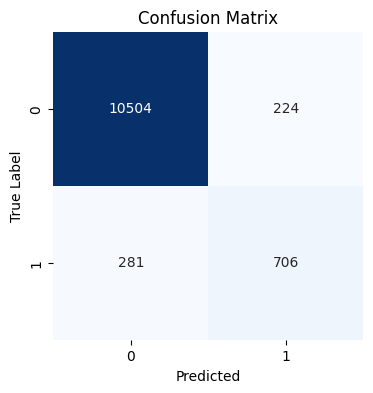

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

y_pred = resnet_CBAM_deep_wide_model.predict(X_test)
y_pred_binary = np.where(y_pred < 0.5, 0, 1)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
loss, acc, prec, rec, f1 = resnet_CBAM_deep_wide_model.evaluate(X_test, y_test, verbose=0)
print(prec)
print(rec)

0.7591397762298584
0.7152988910675049


## ResNet Full data binary

In [ ]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train.reshape(-1), y_val, y_test.reshape(-1)), axis=0)

In [ ]:
batch_size = 512
epochs = 9

resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=1)

history = resnet_CBAM_deep_wide_model.fit(
    class_weight = class_weights,
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
).history

resnet_CBAM_deep_wide_model.save("/content/drive/My Drive/AI_BIO_Project/models/ResNet_train_val_test_2_class")

Epoch 1/9
249/249 [==============================] - 110s 281ms/step - loss: 0.2184 - accuracy: 0.9253 - precision: 0.8952 - recall: 0.8981 - f1_score: 0.8943
Epoch 2/9
249/249 [==============================] - 71s 287ms/step - loss: 0.1868 - accuracy: 0.9315 - precision: 0.9082 - recall: 0.9011 - f1_score: 0.9002
Epoch 3/9
249/249 [==============================] - 71s 286ms/step - loss: 0.1568 - accuracy: 0.9422 - precision: 0.9182 - recall: 0.9218 - f1_score: 0.9201
Epoch 4/9
249/249 [==============================] - 71s 285ms/step - loss: 0.1391 - accuracy: 0.9494 - precision: 0.9276 - recall: 0.9326 - f1_score: 0.9302
Epoch 5/9
249/249 [==============================] - 71s 285ms/step - loss: 0.1291 - accuracy: 0.9539 - precision: 0.9338 - recall: 0.9387 - f1_score: 0.9356
Epoch 6/9
249/249 [==============================] - 71s 285ms/step - loss: 0.1473 - accuracy: 0.9467 - precision: 0.9234 - recall: 0.9294 - f1_score: 0.9252
Epoch 7/9
249/249 [==============================] 

## Final Test

In [ ]:
dataset_path = Path(ROOT_PATH) / "dataset/test/7";
subjects, frequencies, ppgs, peaks, labels = load_data(path = dataset_path)

In [ ]:
for i in range(0, len(ppgs)):
  print(len(ppgs[i]))

20549413
19317499


In [ ]:
resampled_ppgs = []
for i in range(len(ppgs)):
   signal_seconds = len(ppgs[i])/frequencies[i]
   n_samples = signal_seconds * 250
   resampled_ppgs.append(scipy.signal.resample(ppgs[i] , int(n_samples)))

In [ ]:
peaks_rescaled = []
for i in range(len(peaks)):
    tmp = []
    for j in range(len(peaks[i])):
        tmp.append(int(round(peaks[i][j] * (250 / frequencies[i]), 0)))
    peaks_rescaled.append(tmp)

In [ ]:
!pip install pywavelet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00


In [ ]:
from skimage.restoration import denoise_wavelet
from skimage.restoration import estimate_sigma
ppgs_denoised = []

for i in range(len(resampled_ppgs)):
  ppgs_denoised.append(denoise_wavelet(resampled_ppgs[i], sigma=2.5, wavelet="sym9", method='VisuShrink', wavelet_levels=3, mode='hard', rescale_sigma='True'))

print(len(resampled_ppgs))
print(len(ppgs_denoised))

2
2


In [ ]:
def create_windows(subjects, frequence, ppgs, peaks, half_window = 3):
  ids, X, y = [], [], []
  for i, s in enumerate(subjects):
    for j, peak in enumerate(peaks[i]):
        delta = int(half_window*frequence)
        zero_signal = np.arange(0,half_window*2*frequence, 1/frequence)
        beat = []
        if((peak - delta) < 0):
          beat = np.array(ppgs[i][0:peak + delta])
          beat = np.pad(beat, (delta - peak, 0), mode = 'constant')
          beat = beat.tolist()
        elif((peak + delta) > len(ppgs[i]) - 1):
          beat = np.array(ppgs[i][peak - delta:len(ppgs[i]) - 1])
          beat = np.pad(beat, (0, delta - (len(ppgs[i]) - 1 - peak)), mode = 'constant')
          beat = beat.tolist()
        else:
          beat = ppgs[i][peak - delta:peak + delta]
        ids.append(s)
        X.append(beat)
  return X, ids

In [ ]:
Xtf, idstf = create_windows(subjects, 250, ppgs_denoised, peaks_rescaled, half_window = 0.5)

In [ ]:
df = pd.read_csv("/content/drive/My Drive/AI_BIO_Project/dataset/mean_std.csv")
mean, std = df.iloc[0][0], df.iloc[0][1]

print(mean, std)

Xtf = (Xtf - mean)/std

-0.1137033469584191 0.9603644414643936


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras.models import load_model
import tensorflow_addons as tfa


model = load_model('/content/drive/My Drive/AI_BIO_Project/models/ResNet_train_val_test_2_class', custom_objects={"f1_score":f1_score})

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
y_pred = model.predict(Xtf)

5507/5507 [==============================] - 155s 27ms/step


In [ ]:
# codifica label
y_pred_binary = np.where(y_pred < 0.5, 'N', 'A')

In [ ]:
from scipy.io import savemat
fmap = dict(zip(subjects, frequencies))
out = {}
for s, y in zip(idstf, y_pred_binary):
  if s in out:
      out[s].append(y)
  else:
      out[s] = [y]

fpath = "/content/drive/My Drive/AI_BIO_Project/dataset/predictions/"
for k, v in out.items():
    fname = fpath + k + '_' + str(fmap[k]) + '_ann' + '.mat'
    print(fname)
    savemat(fname, {"labels": np.array(v)})

/content/drive/My Drive/AI_BIO_Project/dataset/predictions/S130_250_ann.mat
/content/drive/My Drive/AI_BIO_Project/dataset/predictions/S131_250_ann.mat


# Multi-class classification - N vs S vs V

In [ ]:
df_train = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/train_SMOTE_cleaned.csv")
df_validation = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/val_cleaned.csv")
df_test = pd.read_csv(Path(ROOT_PATH) / "dataset/stratified/test_cleaned.csv")

In [ ]:
print(df_train.head())

X_train = df_train.drop(['class', "Unnamed: 0"], axis=1)
y_train =  df_train[['class']]

X_val = df_validation.drop(columns=["class", "Unnamed: 0", "ID"])
ids_val = df_validation[['ID']]
y_val = df_validation[['class']]
print(y_val.value_counts())

X_test = df_test.drop(columns=["class", "Unnamed: 0", "ID"])
ids_test = df_test[['ID']]
y_test = df_test[['class']]
print(y_test.value_counts())

   Unnamed: 0        f1        f2        f3        f4        f5        f6  \
0           0 -1.339959 -1.355980 -1.371900 -1.387710 -1.403397 -1.418944   
1           1  1.637414  1.626770  1.612184  1.594152  1.573059  1.549140   
2           2 -0.076289 -0.087689 -0.097616 -0.106358 -0.114128 -0.121065   
3           3  0.725350  0.694318  0.663537  0.633013  0.602747  0.572743   
4           4  0.620208  0.574752  0.530036  0.486250  0.443522  0.402050   

         f7        f8        f9  ...      f242      f243      f244      f245  \
0 -1.434336 -1.449563 -1.464613  ... -1.188418 -1.206823 -1.225316 -1.243819   
1  1.522659  1.493807  1.462767  ...  1.220679  1.272116  1.320695  1.365562   
2 -0.127325 -0.133063 -0.138462  ... -1.410262 -1.428318 -1.448046 -1.467480   
3  0.543002  0.513524  0.484310  ... -1.294874 -1.298746 -1.303426 -1.310058   
4  0.362152  0.324016  0.287721  ... -0.735906 -0.609362 -0.480653 -0.352181   

       f246      f247      f248      f249      f250  cla

In [ ]:
print(y_train.shape)
print(y_val.shape)

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(y_val)

np.array(y_train).reshape(-1)
y_val = np.array(y_val).reshape(-1)

class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                     classes=np.unique(y_train),
                                                     y=np.ravel(y_train))
class_weights = dict(zip([0, 1, 2], class_weights))

print(class_weights)

y_train = to_categorical(y_train)
y_val = to_categorical(numeric_labels)

perm = np.random.permutation(len(y_train))
y_train = y_train[perm]
X_train = X_train.iloc[perm].reset_index(drop=True)

print(y_train.shape)
print(y_val.shape)

numeric_labels = label_encoder.fit_transform(y_test)
y_test = to_categorical(numeric_labels)

(93345, 1)
(21919, 1)
{0: 0.6173978609837887, 1: 1.3072430888160658, 2: 1.6251436331348585}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(93345, 3)
(21919, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## ResNet

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
def CBAM_block(in_block, ch, ratio=16):
    # 1. Channel attention
    avg_pool = tf.reduce_mean(in_block, axis = (1), keepdims = True)
    max_pool = tf.reduce_max(in_block, axis = (1), keepdims = True)

    dense1 = Dense(ch//ratio, activation = 'relu')
    avg_reduced = dense1(avg_pool)
    max_reduced = dense1(max_pool)

    dense2 = Dense(ch)
    avg_attention = dense2(avg_reduced)
    max_attention = dense2(max_reduced)

    x = tf.add(avg_attention, max_attention)
    x = tf.nn.sigmoid(x)
    x = tf.multiply(in_block, x)

    # 2. Spatial attention
    y_mean = tf.reduce_mean(x, axis = -1, keepdims=True)
    y_max = tf.reduce_max(x, axis=-1, keepdims=True)

    y = tf.concat([y_mean, y_max], axis = -1)
    y = tf.keras.layers.Conv1D(filters=1, kernel_size=7, padding='same', activation=tf.nn.sigmoid)(y)

    # 3. Combination
    y = tf.multiply(x, y)

    return y

In [ ]:
def ResBs_CBAM_Conv(block_input, num_filters):
    # 0. Filter Block input and BatchNormalization
    block_input_short = Conv1D(num_filters, kernel_size=7, strides=2,  padding = 'valid')(block_input)
    block_input_short = BatchNormalization()(block_input_short)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding= 'valid')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.4)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    CBAM = CBAM_block(norm2, num_filters, ratio=16)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input_short, CBAM])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def ResBs_CBAM_Identity(block_input, num_filters):

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.4)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    CBAM = CBAM_block(norm2, num_filters, ratio=16)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, CBAM])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

# model integrating deep + wide
def resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=1):
    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    signal_input = Input(shape=(win_len, ch), name='PPG_signal')

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(signal_input)
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)

    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks

    # First two ResNet blocks are identity blocks
    ResNet = ResBs_CBAM_Identity(ResNet, 64)
    ResNet = ResBs_CBAM_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M):
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_CBAM_Conv(ResNet, filters)
        ResNet = ResBs_CBAM_Identity(ResNet, filters)

    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)
    shared_path = Dense(classes, activation='softmax', name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs:
    model = tf.keras.Model(inputs=[signal_input],outputs=shared_path)
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[
                      'accuracy',
                      tfa.metrics.F1Score(average='micro', num_classes=3, name = 'f1_score_micro'),
                      tfa.metrics.F1Score(average='macro', num_classes=3, name = 'f1_score_macro'),
                      tf.keras.metrics.Precision(class_id=0),
                      tf.keras.metrics.Recall(class_id=0),
                      tf.keras.metrics.Precision(class_id=1),
                      tf.keras.metrics.Recall(class_id=1),
                      tf.keras.metrics.Precision(class_id=2),
                      tf.keras.metrics.Recall(class_id=2)
                      ]
                  )

    return model

In [ ]:
batch_size = 512
epochs = 200

resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=6, ch=1, win_len=250, classes=3)

history = resnet_CBAM_deep_wide_model.fit(
    class_weight = class_weights,
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ]
).history

Epoch 1/200
183/183 [==============================] - 92s 209ms/step - loss: 0.6112 - accuracy: 0.7915 - f1_score_micro: 0.7915 - f1_score_macro: 0.7408 - precision_15: 0.9380 - recall_15: 0.8738 - precision_16: 0.7212 - recall_16: 0.6310 - precision_17: 0.6150 - recall_17: 0.6563 - val_loss: 3.2540 - val_accuracy: 0.0790 - val_f1_score_micro: 0.0790 - val_f1_score_macro: 0.1417 - val_precision_15: 0.9687 - val_recall_15: 0.0262 - val_precision_16: 0.0453 - val_recall_16: 0.9072 - val_precision_17: 0.4818 - val_recall_17: 0.2082
Epoch 2/200
183/183 [==============================] - 35s 191ms/step - loss: 0.4517 - accuracy: 0.8434 - f1_score_micro: 0.8434 - f1_score_macro: 0.8053 - precision_15: 0.9541 - recall_15: 0.9013 - precision_16: 0.8000 - recall_16: 0.7203 - precision_17: 0.7044 - recall_17: 0.7516 - val_loss: 2.8226 - val_accuracy: 0.1715 - val_f1_score_micro: 0.1715 - val_f1_score_macro: 0.2098 - val_precision_15: 0.9911 - val_recall_15: 0.1167 - val_precision_16: 0.0458 - v

In [ ]:
resnet_CBAM_deep_wide_model.save(Path(ROOT_PATH) / "models/resnet_3_class_best")

In [ ]:
resnet_CBAM_deep_wide_model = tfk.models.load_model(Path(ROOT_PATH) / "models/resnet_3_class_best")

In [ ]:
metrics = resnet_CBAM_deep_wide_model.evaluate(X_val, y_val)

685/685 [==============================] - 22s 27ms/step - loss: 0.2980 - accuracy: 0.9257 - f1_score_micro: 0.9257 - f1_score_macro: 0.6577 - precision_15: 0.9809 - recall_15: 0.9579 - precision_16: 0.4470 - recall_16: 0.6357 - precision_17: 0.4987 - recall_17: 0.4600


In [ ]:
metric_names = history.keys()

print("Nomi delle metriche:", metric_names)

for metric_name, result in zip(metric_names, metrics):
    print(f"{metric_name}: {result}")

Nomi delle metriche: dict_keys(['loss', 'accuracy', 'f1_score_micro', 'f1_score_macro', 'precision_15', 'recall_15', 'precision_16', 'recall_16', 'precision_17', 'recall_17', 'val_loss', 'val_accuracy', 'val_f1_score_micro', 'val_f1_score_macro', 'val_precision_15', 'val_recall_15', 'val_precision_16', 'val_recall_16', 'val_precision_17', 'val_recall_17'])
loss: 0.29797613620758057
accuracy: 0.925680935382843
f1_score_micro: 0.925680935382843
f1_score_macro: 0.6576704978942871
precision_15: 0.9809057116508484
recall_15: 0.9578721523284912
precision_16: 0.44701087474823
recall_16: 0.6357488036155701
precision_17: 0.49868765473365784
recall_17: 0.4600484371185303


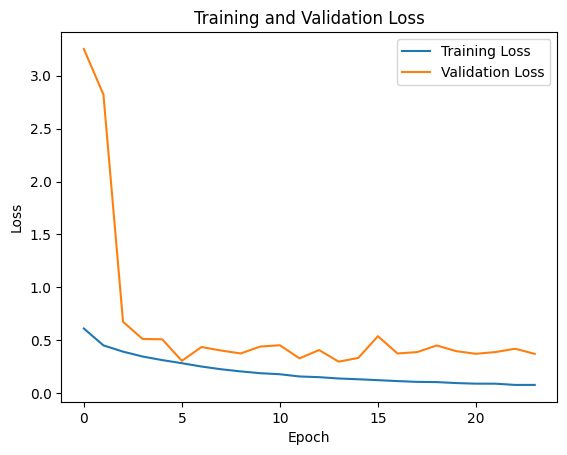

In [ ]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

685/685 [==============================] - 13s 18ms/step


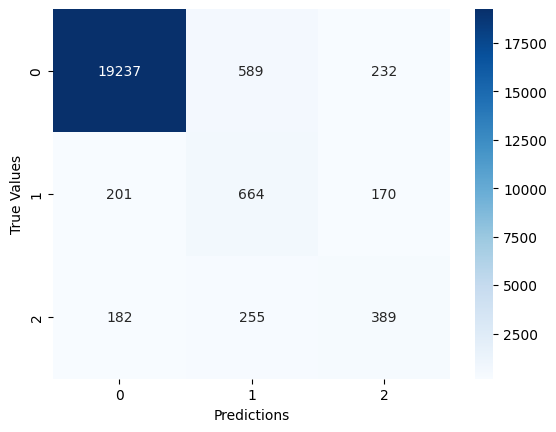

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

y_pred = resnet_CBAM_deep_wide_model.predict(X_val)
predictions = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_val, axis=1), predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()

## ResNet on test


In [ ]:
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

In [ ]:
batch_size = 512
epochs = 14

resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=3)

history = resnet_CBAM_deep_wide_model.fit(
    class_weight = class_weights,
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
).history

resnet_CBAM_deep_wide_model.save("/content/drive/My Drive/AI_BIO_Project/models/resnet_best_full_data_3_class")

Epoch 1/14
226/226 [==============================] - 98s 286ms/step - loss: 0.5303 - accuracy: 0.8234 - f1_score_micro: 0.8234 - f1_score_macro: 0.7513 - precision_18: 0.9523 - recall_18: 0.9001 - precision_19: 0.7233 - recall_19: 0.6338 - precision_20: 0.6253 - recall_20: 0.6729
Epoch 2/14
226/226 [==============================] - 64s 283ms/step - loss: 0.3693 - accuracy: 0.8729 - f1_score_micro: 0.8729 - f1_score_macro: 0.8225 - precision_18: 0.9652 - recall_18: 0.9213 - precision_19: 0.8061 - recall_19: 0.7463 - precision_20: 0.7242 - recall_20: 0.7760
Epoch 3/14
226/226 [==============================] - 64s 283ms/step - loss: 0.3027 - accuracy: 0.8971 - f1_score_micro: 0.8971 - f1_score_macro: 0.8578 - precision_18: 0.9724 - recall_18: 0.9323 - precision_19: 0.8363 - recall_19: 0.8132 - precision_20: 0.7752 - recall_20: 0.8229
Epoch 4/14
226/226 [==============================] - 64s 284ms/step - loss: 0.2503 - accuracy: 0.9165 - f1_score_micro: 0.9165 - f1_score_macro: 0.8853 -

In [ ]:
metrics = resnet_CBAM_deep_wide_model.evaluate(X_test, y_test)

367/367 [==============================] - 13s 30ms/step - loss: 0.3360 - accuracy: 0.9385 - f1_score_micro: 0.9385 - f1_score_macro: 0.6165 - precision_18: 0.9656 - recall_18: 0.9880 - precision_19: 0.5815 - recall_19: 0.4945 - precision_20: 0.4638 - recall_20: 0.2483


In [ ]:
metric_names = history.keys()


print("Nomi delle metriche:", metric_names)

for metric_name, result in zip(metric_names, metrics):
    print(f"{metric_name}: {result}")

Nomi delle metriche: dict_keys(['loss', 'accuracy', 'f1_score_micro', 'f1_score_macro', 'precision_18', 'recall_18', 'precision_19', 'recall_19', 'precision_20', 'recall_20'])
loss: 0.3360428512096405
accuracy: 0.9384549856185913
f1_score_micro: 0.9384549856185913
f1_score_macro: 0.6165032386779785
precision_18: 0.9655643701553345
recall_18: 0.9879754185676575
precision_19: 0.5815450549125671
recall_19: 0.4945255517959595
precision_20: 0.46382978558540344
recall_20: 0.24829156696796417


367/367 [==============================] - 9s 20ms/step


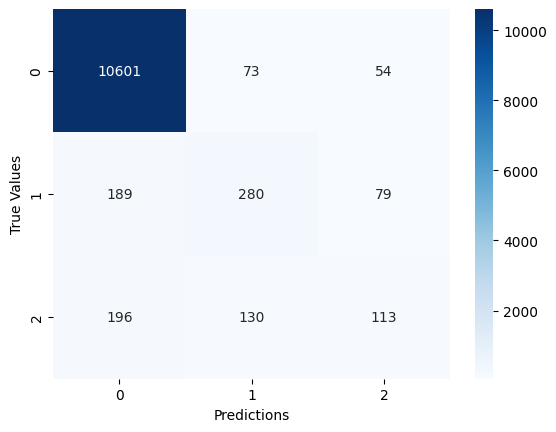

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

y_pred = resnet_CBAM_deep_wide_model.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()

## Embedding

In [ ]:
embedding_extractor = tf.keras.Model(inputs=resnet_CBAM_deep_wide_model.input, outputs=resnet_CBAM_deep_wide_model.layers[-2].output)
embeddings = embedding_extractor.predict(X_val)

685/685 [==============================] - 16s 22ms/step


In [ ]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv(Path(ROOT_PATH) / "dataset/embeddings/embeddings_val.csv", index=False)

In [ ]:
print(embeddings_df.head())

        0         1         2         3         4         5         6    \
0  2.982453  1.712214  0.981860  2.502172  1.690762  1.542969  1.836379   
1  5.980774  2.607445  7.194876  0.879164  2.380799  2.944093  1.779203   
2  3.685455  3.147457  2.952039  2.035690  2.012950  3.191106  1.335903   
3  2.688997  1.748958  3.782044  1.665228  2.227828  3.794558  2.110857   
4  4.009197  1.489903  3.994144  1.092447  1.952549  4.651752  1.349231   

        7         8         9    ...       502       503       504       505  \
0  2.890862  1.950071  0.599166  ...  2.002957  3.095653  3.077605  2.511359   
1  3.104304  9.523761  4.443353  ...  4.658704  2.498772  1.982088  1.016049   
2  1.415425  2.357994  0.923807  ...  1.063025  0.958470  2.476509  1.228822   
3  3.681040  4.551237  0.976118  ...  2.946749  1.448438  1.781553  2.370951   
4  4.404022  5.667860  3.181175  ...  3.105678  1.563763  0.601138  1.441522   

        506       507       508       509       510       511  
0  2

## ResNet Full data

In [ ]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [ ]:
batch_size = 512
epochs = 14

resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=8, ch=1, win_len=250, classes=3)

history = resnet_CBAM_deep_wide_model.fit(
    class_weight = class_weights,
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
).history

resnet_CBAM_deep_wide_model.save("/content/drive/My Drive/AI_BIO_Project/models/ResNet_train_val_test_3_class")

Epoch 1/14
249/249 [==============================] - 106s 278ms/step - loss: 0.4910 - accuracy: 0.8382 - f1_score_micro: 0.8382 - f1_score_macro: 0.7569 - precision_3: 0.9576 - recall_3: 0.9119 - precision_4: 0.7371 - recall_4: 0.6463 - precision_5: 0.6216 - recall_5: 0.6669
Epoch 2/14
249/249 [==============================] - 68s 274ms/step - loss: 0.3665 - accuracy: 0.8753 - f1_score_micro: 0.8753 - f1_score_macro: 0.8141 - precision_3: 0.9666 - recall_3: 0.9279 - precision_4: 0.7979 - recall_4: 0.7328 - precision_5: 0.7117 - recall_5: 0.7530
Epoch 3/14
249/249 [==============================] - 69s 275ms/step - loss: 0.3733 - accuracy: 0.8727 - f1_score_micro: 0.8727 - f1_score_macro: 0.8086 - precision_3: 0.9679 - recall_3: 0.9290 - precision_4: 0.7928 - recall_4: 0.7188 - precision_5: 0.6995 - recall_5: 0.7517
Epoch 4/14
249/249 [==============================] - 68s 274ms/step - loss: 0.2857 - accuracy: 0.9038 - f1_score_micro: 0.9038 - f1_score_macro: 0.8578 - precision_3: 0.9

## Final Test

In [19]:
dataset_path = Path(ROOT_PATH) / "dataset/test/6";
subjects, frequencies, ppgs, peaks, labels = load_data(path = dataset_path)

In [20]:
print(frequencies)

[250, 250]


In [21]:
resampled_ppgs = []
for i in range(len(ppgs)):
   signal_seconds = len(ppgs[i])/frequencies[i]
   n_samples = signal_seconds * 250
   resampled_ppgs.append(scipy.signal.resample(ppgs[i] , int(n_samples)))

In [22]:
peaks_rescaled = []
for i in range(len(peaks)):
    tmp = []
    for j in range(len(peaks[i])):
        tmp.append(int(round(peaks[i][j] * (250 / frequencies[i]), 0)))
    peaks_rescaled.append(tmp)

In [23]:
!pip install pywavelet

In [24]:
from skimage.restoration import denoise_wavelet
from skimage.restoration import estimate_sigma
ppgs_denoised = []

for i in range(len(resampled_ppgs)):
  ppgs_denoised.append(denoise_wavelet(resampled_ppgs[i], sigma=2.5, wavelet="sym9", method='VisuShrink', wavelet_levels=3, mode='hard', rescale_sigma='True'))

print(len(resampled_ppgs))
print(len(ppgs_denoised))

2
2


In [25]:
def create_windows(subjects, frequence, ppgs, peaks, half_window = 3):
  ids, X, y = [], [], []
  for i, s in enumerate(subjects):
    for j, peak in enumerate(peaks[i]):
        delta = int(half_window*frequence)
        zero_signal = np.arange(0,half_window*2*frequence, 1/frequence)
        beat = []
        if((peak - delta) < 0):
          beat = np.array(ppgs[i][0:peak + delta])
          beat = np.pad(beat, (delta - peak, 0), mode = 'constant')
          beat = beat.tolist()
        elif((peak + delta) > len(ppgs[i]) - 1):
          beat = np.array(ppgs[i][peak - delta:len(ppgs[i]) - 1])
          beat = np.pad(beat, (0, delta - (len(ppgs[i]) - 1 - peak)), mode = 'constant')
          beat = beat.tolist()
        else:
          beat = ppgs[i][peak - delta:peak + delta]
        ids.append(s)
        X.append(beat)
  return X, ids

In [26]:
Xtf,dstf = create_windows(subjects, 250, ppgs_denoised, peaks_rescaled, half_window = 0.5)

In [27]:
df = pd.read_csv("/content/drive/My Drive/AI_BIO_Project/dataset/mean_std.csv")
mean, std = df.iloc[0][0], df.iloc[0][1]

print(mean, std)

Xtf = (Xtf - mean)/std

-0.1137033469584191 0.9603644414643936


In [28]:
!pip install tensorflow_addons

In [29]:
from keras.models import load_model
import tensorflow_addons as tfa

model = load_model('/content/drive/My Drive/AI_BIO_Project/models/ResNet_train_val_test_3_class')

In [30]:
def encoding_classes(y):
  mapping_binary = {0: 'N', 1: 'S', 2: 'V'}
  y = np.vectorize(mapping_binary.get)(y)
  return y


In [31]:
y_pred = model.predict(Xtf)

5327/5327 [==============================] - 160s 30ms/step


In [32]:
# codifica label
predictions = np.argmax(y_pred, axis=1)
y_pred = encoding_classes(predictions)

In [33]:
from scipy.io import savemat
fmap = dict(zip(subjects, frequencies))
out = {}
for s, y in zip(dstf, y_pred):
  if s in out:
      out[s].append(y)
  else:
      out[s] = [y]

fpath = "/content/drive/My Drive/AI_BIO_Project/dataset/predictions3/"
for k, v in out.items():
    fname = fpath + k + '_' + str(fmap[k]) + '_ann' + '.mat'
    savemat(fname, {'labels': np.array(v)})

# Explainability

In [ ]:
resnet_CBAM_deep_wide_model = tfk.models.load_model("/content/drive/My Drive/AI_BIO_Project/models/resnet_best_full_data_3_class")

In [ ]:
import cv2
import gc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib as mpl
mpl.style.use('seaborn')
import numpy as np
import itertools
import logging

def multicolored_lines(x,y,heatmap,title_name):
    fig, ax = plt.subplots()
    lc = colorline(x, y, heatmap,cmap='rainbow')
    plt.colorbar(lc)
    lc.set_linewidth(2)
    lc.set_alpha(0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.title(title_name)
    plt.grid(False)
    plt.show()

def colorline(x, y, heatmap,cmap='rainbow'):
    z = np.array(heatmap)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc

def compute_cam_1d_output (model, data , layer_name , N):
        """
        model: The Deep Learning model
        data : A input data. Data shape has to be (n,1,1)
        layer_name : The target layer for explanation
        N: signal length in seconds
        """
        # input layer, model output layer and target layer
        grad_model = tf.keras.models.Model(inputs=[model.inputs],outputs=[model.get_layer(layer_name).output, model.output])

        # Getting gradients of input layer, model output layer (predictions) and target layer
        with tf.GradientTape() as tape:
            inputs = np.expand_dims(data,axis=0)
            conv_outs, predictions = grad_model(inputs)
            class_idx = tf.argmax(predictions[0])
            y_c = predictions[:, class_idx]

        batch_grads = tape.gradient(y_c, conv_outs)
        grads = batch_grads[0]

        # First, second and third derivative of output gradient
        first = tf.exp(y_c) * grads
        second = tf.exp(y_c) * tf.pow(grads, 2)
        third = tf.exp(y_c) * tf.pow(grads, 3)

        # Compute salienty maps for the class_idx prediction
        global_sum = tf.reduce_sum(tf.reshape(conv_outs[0], shape=(-1, first.shape[1])), axis=0)
        alpha_num = second
        alpha_denom = second * 2.0 + third * tf.reshape(global_sum, shape=(1,1,first.shape[1]))
        alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones(shape=alpha_denom.shape))
        alphas = alpha_num / alpha_denom
        weights = tf.maximum(first, 0.0)
        alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas, axis=0), axis=0)
        alphas /= tf.reshape(alpha_normalization_constant, shape=(1,1,first.shape[1]))
        alphas_thresholding = np.where(weights, alphas, 0.0)

        alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas_thresholding, axis=0),axis=0)
        alpha_normalization_constant_processed = tf.where(alpha_normalization_constant != 0.0, alpha_normalization_constant,
                                                          tf.ones(alpha_normalization_constant.shape))

        alphas /= tf.reshape(alpha_normalization_constant_processed, shape=(1,1,first.shape[1]))
        deep_linearization_weights = tf.reduce_sum(tf.reshape((weights*alphas), shape=(-1,first.shape[1])), axis=0)
        grad_CAM_map = tf.reduce_sum(deep_linearization_weights * conv_outs[0], axis=-1)

        # Normalization
        cam = np.maximum(grad_CAM_map, 0)
        cam = cam / np.max(cam)

        # Turn result into a heatmap
        heatmap=[]
        heatmap.append(cam.tolist())
        big_heatmap = cv2.resize(np.array(heatmap), dsize=(data.shape[0], 500),interpolation=cv2.INTER_CUBIC)
        x = np.linspace(0, N, data.shape[0])
        plt.style.use("seaborn-whitegrid")
        multicolored_lines(x,np.array([i for i in data]),big_heatmap[0],f"GradCAM ++ Visualization")

<ipython-input-17-3828ffb7915a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
y_pred = resnet_CBAM_deep_wide_model.predict(X_test)

367/367 [==============================] - 21s 38ms/step


In [ ]:
signal_map = {}

for i, y_p in enumerate(y_pred):
  if(np.argmax(y_p) == np.argmax(y_test[i]) and np.argmax(y_p) not in signal_map.keys()):
    signal_map[np.argmax(y_p)] = X_test.iloc[i].values

<ipython-input-17-3828ffb7915a>:91: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


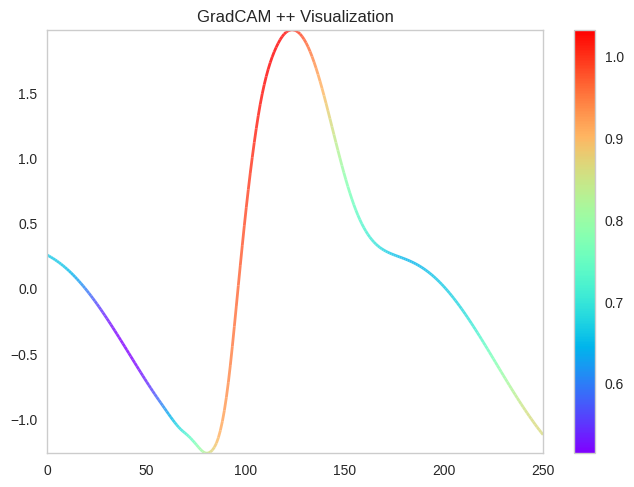

<ipython-input-17-3828ffb7915a>:91: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


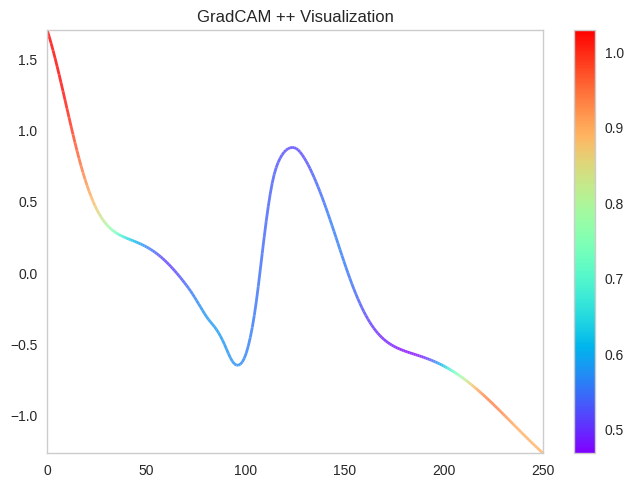

<ipython-input-17-3828ffb7915a>:91: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


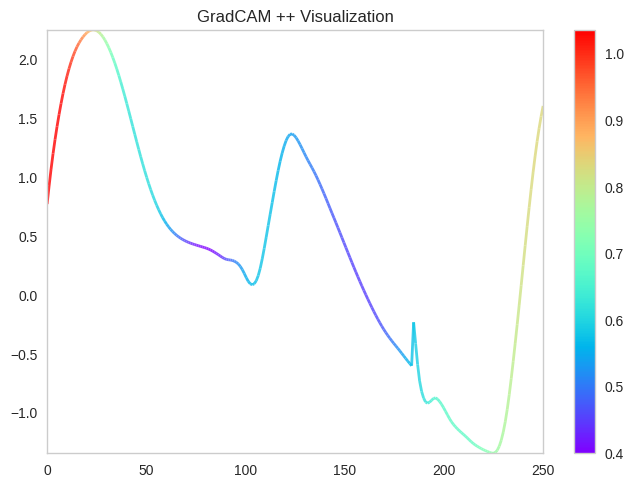

In [ ]:
compute_cam_1d_output(resnet_CBAM_deep_wide_model, signal_map[0], 'activation_114', 250)
compute_cam_1d_output(resnet_CBAM_deep_wide_model, signal_map[1], 'activation_114', 250)
compute_cam_1d_output(resnet_CBAM_deep_wide_model, signal_map[2], 'activation_114', 250)